In [0]:
import os
import time
import torch
import shutil
import zipfile
import numpy as np
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.autograd import Variable
from time import time, strftime, gmtime
from torchvision.models import resnet50
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor

In [0]:
# remove data folder with all its content if present

!rm -rf data

In [0]:
# copy and extract dataset from drive

def extract(source='data/celeb.zip'):
    if not os.path.exists(source):
        print('Dataset zip not found or already extracted')
    else:
        print('Dataset zip found. Extracting....')
        zip_file = source
        zip_ref = zipfile.ZipFile(zip_file, 'r')
        zip_ref.extractall(path="data")
        zip_ref.close()

def create_data():
    if not os.path.exists('data'):
        os.makedirs('data')
    src = 'drive/My Drive/celeb.zip'
    dst = 'data/celeb.zip'
    print('Copying Dataset zip from Drive....')
    start = time()
    shutil.copyfile(src, dst)
    extract(source='data/celeb.zip')
    end = time()
    print('Copied and Extracted | Time elapsed --> {}'.format(strftime("%H:%M:%S", gmtime(end - start))))

create_data()

Copying Dataset zip from Drive....
Dataset zip found. Extracting....
Copied and Extracted | Time elapsed --> 00:00:13


In [0]:
# utility functions to visualize a sample image, save model ckpt and save loss and accuracy

def visualize(data_loader=None, tags=[]):
    images, label = iter(data_loader).next()
    idx = 1
    print('Celebrity --> {}'.format(tags[label[idx]]))
    transform = ToPILImage()
    img = transform(images[idx])
    plt.axis('off')
    plt.imshow(img)


def save_checkpoint(model=None):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model, "model/model.pt")


def save_metric(metric=[], name="losses.npy", result_dir="result"):
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    metric_name = os.path.join(result_dir, name)
    np.save(metric_name, metric)

In [0]:
# load dataset

def load_data(batch_size=32, source='data/celeb'):
    data = datasets.ImageFolder(root=source,
                                transform=Compose([Resize((224, 224)),
                                                   RandomHorizontalFlip(),
                                                   ToTensor()]))

    data_loader = DataLoader(data,
                             batch_size=batch_size,
                             shuffle=True)

    return data_loader

In [0]:
# hyperparameters

torch.manual_seed(1)
device = 'cuda'
source = 'data/celeb'
num_epochs = 10
batch_size = 32
lr = 1e-3
mod = 50

In [0]:
def train(num_epochs=10, data_loader=None, optimizer=None, device='cuda', model=None, criterion=None, mod=50, batch_size=32):
    losses, accuracy = [], []
    print("Training....")
    start = time()
    for epoch in range(num_epochs):
        epoch_start = time()
        for i, (img, label) in enumerate(data_loader):
            optimizer.zero_grad()
            label = torch.LongTensor(label.view(-1).numpy())
            img, label = Variable(img.to(device)), Variable(label.to(device))

            # forward pass
            output = model(img)
            loss = criterion(output, label)

            # backward pass
            loss.backward()
            optimizer.step()

            pred_prob, pred_label = torch.max(output, dim=1)
            acc = (pred_label == label).sum().item() * 1.0 / batch_size

            if i % mod == 0:
                print('{} --> {}'.format(label[:4], pred_label[:4]))
                print('Epoch = {} | Batch = {} | Loss = {:.6f} | Accuracy = {:.6f}'.format(epoch + 1, i + 1, loss, acc))
                losses.append(loss)
                accuracy.append(acc)
        save_checkpoint(model=model)
        save_metric(metric=losses, name='losses.npy', result_dir='result')
        save_metric(metric=accuracy, name='accuracy.npy', result_dir='result')
        end = time()
        print('Time Elapsed in Epoch {} --> {}'.format(epoch + 1, strftime('%H:%M:%S', gmtime(end - epoch_start))))
    end = time()
    print('Training Done | Time Elapsed --> {}'.format(strftime('%H:%M:%S', gmtime(end - start))))

In [0]:
def main():
    model = resnet50(pretrained=True).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    data_loader = load_data(batch_size=batch_size, source=source)
    tags = np.load('data/tags.npy')

    train(num_epochs=num_epochs,
          data_loader=data_loader,
          optimizer=optimizer,
          device=device,
          model=model,
          criterion=criterion,
          mod=mod,
          batch_size=batch_size)

Celebrity --> Christian Bale


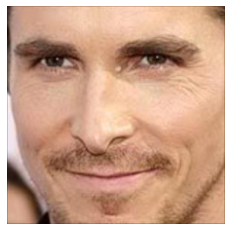

In [50]:
tags = np.load('data/tags.npy')
data_loader = load_data(batch_size=batch_size, source=source)
visualize(data_loader=data_loader, tags=tags)

In [55]:
if __name__ == '__main__':
    print('Training on {}'.format(torch.cuda.get_device_name(0)))
    main()

Training on Tesla T4
Training....
tensor([80, 93, 31, 37], device='cuda:0') --> tensor([722, 836, 728, 174], device='cuda:0')
Epoch = 1 | Batch = 1 | Loss = 9.405534 | Accuracy = 0.000000
tensor([85,  7, 45, 94], device='cuda:0') --> tensor([90, 80, 46, 46], device='cuda:0')
Epoch = 1 | Batch = 51 | Loss = 4.779548 | Accuracy = 0.000000
tensor([73, 28,  8,  1], device='cuda:0') --> tensor([81, 85, 81, 95], device='cuda:0')
Epoch = 1 | Batch = 101 | Loss = 4.513935 | Accuracy = 0.000000
tensor([26, 37, 92, 55], device='cuda:0') --> tensor([21, 76, 76, 38], device='cuda:0')
Epoch = 1 | Batch = 151 | Loss = 4.680436 | Accuracy = 0.031250
tensor([47, 19, 16, 34], device='cuda:0') --> tensor([86,  3, 97, 49], device='cuda:0')
Epoch = 1 | Batch = 201 | Loss = 4.483742 | Accuracy = 0.000000
tensor([48, 20, 31, 83], device='cuda:0') --> tensor([98, 13, 64, 76], device='cuda:0')
Epoch = 1 | Batch = 251 | Loss = 4.194130 | Accuracy = 0.031250
tensor([62, 64, 80, 35], device='cuda:0') --> tensor(

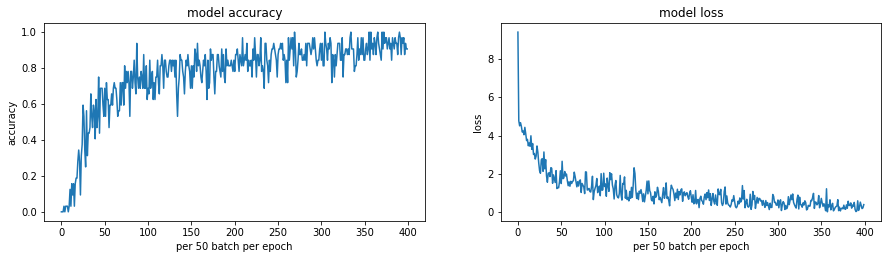

In [57]:
accuracy = np.load('result/accuracy.npy', allow_pickle=True) 
losses = np.load('result/losses.npy', allow_pickle=True)

# plotting entire graph
plt.figure(1, figsize=(15, 8))

# plotting accuracy graph
plt.subplot(221)
plt.plot(accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('per 50 batch per epoch')

# plotting loss graph
plt.subplot(222)
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('per 50 batch per epoch')

# save plot
plt.savefig('result/plot.jpg')

# show graph
plt.show()

In [0]:
import shutil

for dirs in os.listdir('.'):
    if dirs == 'model' or dirs == 'result':
        shutil.make_archive(dirs, 'zip', dirs)

In [0]:
# copy zip file back to drive

import time
import shutil

start = time()

src_file = 'model.zip'
dst_file = 'drive/My Drive/model.zip'
shutil.copyfile(src_file, dst_file)

print('Copied Zip File to Drive | Time elapsed --> {} seconds'.format(strftime("%H:%M:%S", gmtime(time()-start))))